# **DATA**

In [252]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

### Downloading data

In [253]:
## Download raw data from yfinance
ticker = 'EURUSD=X'
print(f"Tải dữ liệu {ticker} từ yahoo finance.")
data = yf.download(ticker, start='2015-01-01', end='2025-10-01', progress=False, auto_adjust=False)
data.tail()

Tải dữ liệu EURUSD=X từ yahoo finance.


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,,
2025-09-24,1.181447,1.181447,1.181656,1.173131,1.181447,0
2025-09-25,1.174467,1.174467,1.175433,1.166793,1.174467,0
2025-09-26,1.166276,1.166276,1.170220,1.165936,1.166276,0
2025-09-29,1.170823,1.170823,1.175489,1.170535,1.170823,0
2025-09-30,1.173144,1.173144,1.175945,1.171317,1.173144,0


In [254]:
## Xử lý MultiIndex (Flatten Columns)
if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-01,1.209863,1.209863,1.209863,1.209863,1.209863,0
2015-01-02,1.208941,1.208941,1.208956,1.201080,1.208868,0
2015-01-05,1.194643,1.194643,1.197590,1.188909,1.195500,0
2015-01-06,1.193902,1.193902,1.197000,1.188693,1.193830,0
2015-01-07,1.187536,1.187536,1.190000,1.180401,1.187479,0


In [255]:
df = data.copy()

### Cleaning Data

In [256]:
## Loại bỏ dữ liệu phi logic (Logically Inconsistent)
# Rule A: Volume không được âm
mask_vol = df['Volume'] >= 0

# Rule B: High phải lớn hơn hoặc bằng Low
mask_hl = df['High'] >= df['Low']

# Rule C: Close và Open phải nằm trong khoảng High-Low (chấp nhận sai số nhỏ do làm tròn)
epsilon = 1e-4 # Sửa lỗi làm tròn số khi code
mask_rng_close = (df['Close'] <= df['High'] + epsilon) & (df['Close'] >= df['Low'] - epsilon)
mask_rng_open  = (df['Open']  <= df['High'] + epsilon) & (df['Open']  >= df['Low'] - epsilon)

# Tổng hợp các dòng HỢP LỆ
valid_rows = mask_vol & mask_hl & mask_rng_close & mask_rng_open

# Đếm số dòng lỗi
invalid_count = len(df) - valid_rows.sum()
if invalid_count > 0:
    print(f"Phát hiện {invalid_count} dòng lỗi logic (trên dữ liệu gốc)")
    # In thử 1 dòng lỗi để kiểm tra xem có phải lỗi thật không
    # print("Ví dụ dòng lỗi:", df[~valid_rows].head(1))
    print('Đã loại bỏ dữ liệu phi logic.')
    df = df[valid_rows]
else:
    print('Không tồn tại dữ liệu phi logic.')

Phát hiện 46 dòng lỗi logic (trên dữ liệu gốc)
Đã loại bỏ dữ liệu phi logic.


In [257]:
## Chuẩn hóa tên cột
df['close'] = df['Adj Close']
df = df.rename(columns={
        'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume'
    })

# Chỉ giữ các cột OHLCV
required_cols = ['open', 'high', 'low', 'close', 'volume']
df = df[required_cols]

df.tail()

Price,open,high,low,close,volume
Date,,,,,
2025-09-24,1.181447,1.181656,1.173131,1.181447,0
2025-09-25,1.174467,1.175433,1.166793,1.174467,0
2025-09-26,1.166276,1.170220,1.165936,1.166276,0
2025-09-29,1.170823,1.175489,1.170535,1.170823,0
2025-09-30,1.173144,1.175945,1.171317,1.173144,0


In [258]:
# Missing Values
## LOCF (Last Observation Carried Forward)
df = df.ffill()
## Delete NaN data
df = df.dropna()

In [259]:
# Kiểm tra biến động cực đoan (Fat Tails Check)
# Không xóa blindly các outlier, chỉ flag.
# In cảnh báo nếu giá biến động > 20% một ngày để kiểm tra. (Kiểm tra có thể do sáp nhập M&A, Earning Suprise hoặc Flash Crash - Sập giá)
daily_ret = df['close'].pct_change().abs()
extreme_moves = daily_ret[daily_ret > 0.20] # Biến động > 20%

if not extreme_moves.empty:
    print(f"\n Phát hiện {len(extreme_moves)} ngày biến động giá > 20%.")
    print(extreme_moves.tail(3)) # In ra 3 ngày gần nhất

In [260]:
# Kiểm tra Volume = 0 (Thanh khoản kém)
# Thanh khoản thấp (Low Liquidity)
zero_vol_count = (df['volume'] == 0).sum()
if zero_vol_count > 0:
    print(f"Lưu ý: Có {zero_vol_count} ngày không có giao dịch (Volume=0).")
    # Với SMA nên giữ lại không xóa để tránh gãy chuỗi.

Lưu ý: Có 2752 ngày không có giao dịch (Volume=0).


### Plotting

C:\Users\Tam Nguyen\AppData\Local\Programs\Python\Python314\Lib\site-packages\mplfinance\plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


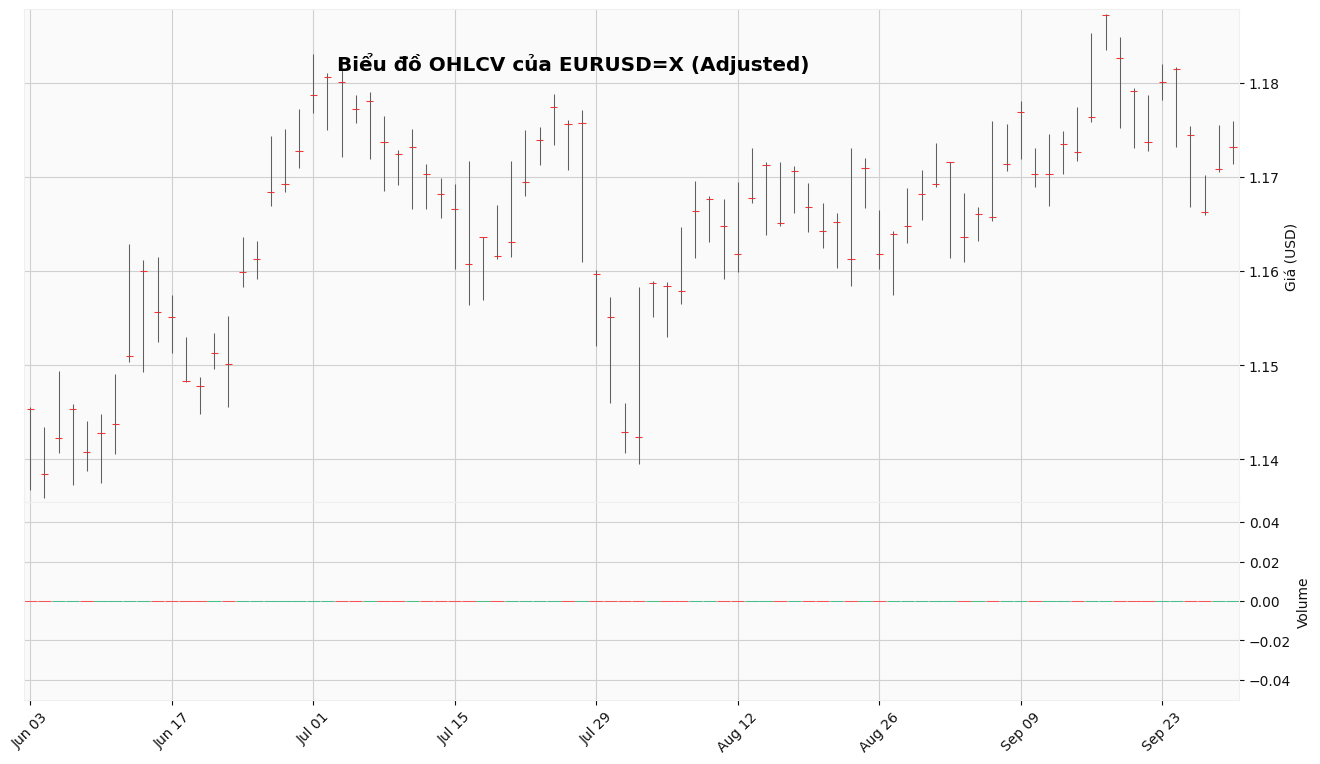

In [261]:
# Thiết lập giao diện (Style)
# 'yahoo': Phong cách giống Yahoo Finance (Nến xanh/đỏ)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 10})

# Vẽ biểu đồ
# type='candle': Biểu đồ nến
# volume=True: Hiển thị Volume bên dưới
df_short = df.loc['2025-06-01':'2025-10-01']
mpf.plot(df_short,
         type='candle',
         style=my_style,
         title=f'Biểu đồ OHLCV của {ticker} (Adjusted)',
         ylabel='Giá (USD)',
         ylabel_lower='Volume',
         volume=True,
         figsize=(14, 8),
         tight_layout=True)


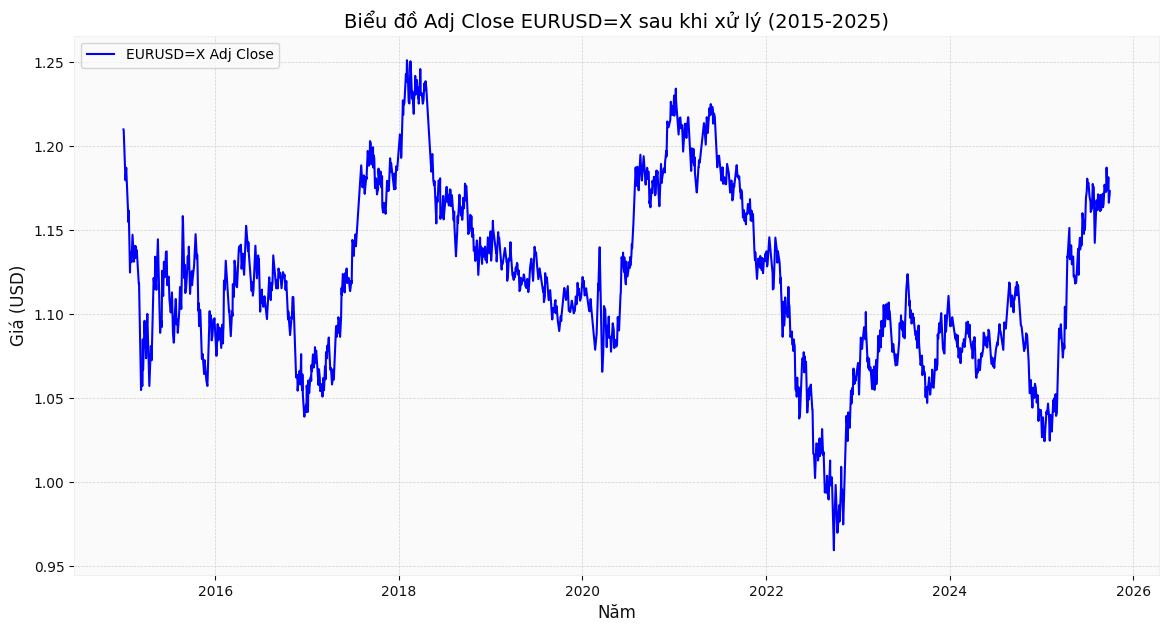

In [262]:
# Vẽ biểu đồ thể hiện Adj Close
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label=f'{ticker} Adj Close', color='blue', linewidth=1.5)

plt.title(f'Biểu đồ Adj Close {ticker} sau khi xử lý (2015-2025)', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

# **TREND-FOLLOWING SIGNAL**
## SMA (Simple Moving Average)
- The N-day SMA is the average close price of the past N days.
- Formula: $SMA_{N} = \frac{1}{N} \sum_{i=0}^{N-1} C_{t-i}$
- **Drawback:** It treats all prices of the past N days equally, failing to give more weight to recent data.

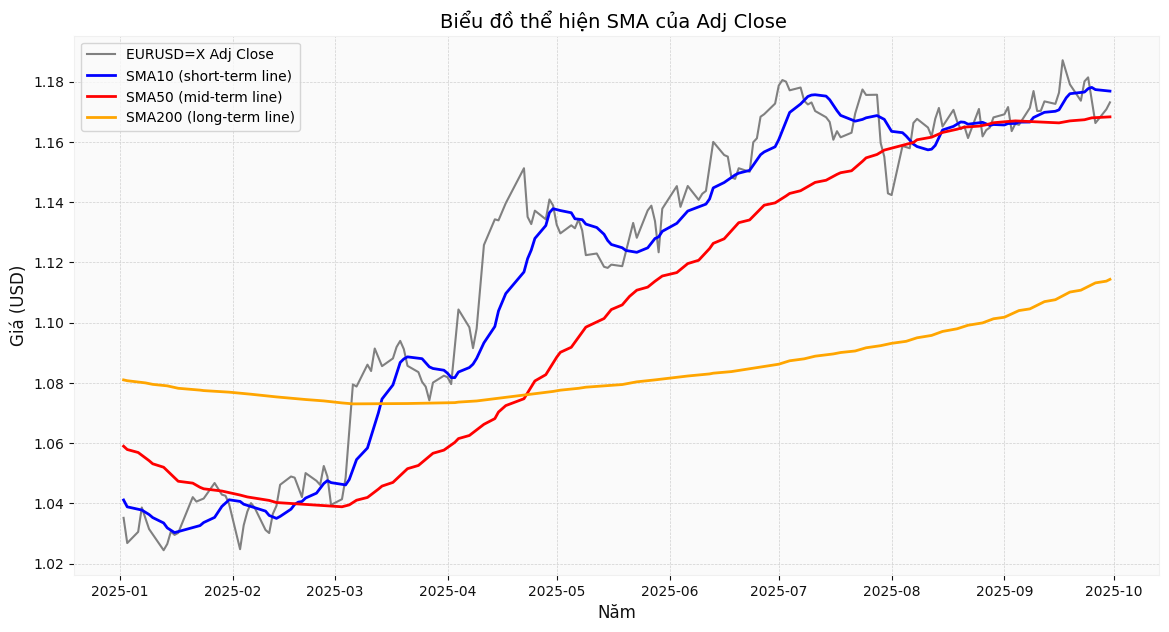

In [263]:
# Vẽ biểu đồ thể hiện SMA10 (short-term line), SMA50 (mid-term line), SMA200 (long-term line)

df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

df_plot = df.loc['2025-01-01':'2025-10-30'].copy()

plt.figure(figsize=(14, 7))
plt.plot(df_plot.index, df_plot['close'], label=f'{ticker} Adj Close', color='gray', linewidth=1.5)
plt.plot(df_plot.index, df_plot['SMA_10'], label='SMA10 (short-term line)', color='blue', linewidth=2)
plt.plot(df_plot.index, df_plot['SMA_50'], label='SMA50 (mid-term line)', color='red', linewidth=2)
plt.plot(df_plot.index, df_plot['SMA_200'], label='SMA200 (long-term line)', color='orange', linewidth=2)

plt.title(f'Biểu đồ thể hiện SMA của Adj Close ', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

- If the market closes above its 200-day SMA line, the market is in uptrend; if the market closes below its 200-day SMA line, the market is in downtrend

### Crossover Strategy
- Tín hiệu MUA (Long Entry): Khi đường SMA 50 (Short-term Line) cắt lên trên đường SMA 200 (Long-term line). Đây gọi là "Golden Cross", báo hiệu thị trường bước vào xu hướng tăng dài hạn.
- Tín hiệu BÁN/THOÁT (Exit/Short): Khi đường SMA 50 cắt xuống dưới đường SMA 200. Đây gọi là "Death Cross", báo hiệu xu hướng giảm.

In [264]:
def strategy_sma_crossover(data_input):
    df_sma = data_input.copy()

    # 1. Tính toán SMA50 và SMA200
    df_sma['SMA_50'] = df_sma['close'].rolling(window=50).mean()
    df_sma['SMA_200'] = df_sma['close'].rolling(window=200).mean()

    # 2. Tạo Tín hiệu (Signal)
    # Signal = 1 khi SMA_50 > SMA_200 (Giữ cổ phiếu - Mua cổ phiếu)
    # Signal = 0 khi SMA_50 <= SMA_200 (Giữ tiền mặt - Bán hết cổ phiếu)
    df_sma['Signal'] = 0
    df_sma.loc[df_sma['SMA_50'] > df_sma['SMA_200'], 'Signal'] = 1

    # 3. Tính Lợi nhuận Chiến lược (Strategy Returns)
    # Market Return: Lợi nhuận hàng ngày của cổ phiếu
    df_sma['Market_Return'] = df_sma['close'].pct_change()

    # Strategy Return: Lợi nhuận khi theo tín hiệu
    # shift(1) là quan trọng: Tín hiệu hôm nay dùng để giao dịch cho ngày mai (tránh look-ahead bias)
    df_sma['Strategy_Return'] = df_sma['Signal'].shift(1) * df_sma['Market_Return']

    # 4. Tính Lợi nhuận tích lũy (Cumulative Returns) - Lãi kép
    df_sma['Cumulative_Market'] = (1 + df_sma['Market_Return']).cumprod()
    df_sma['Cumulative_Strategy'] = (1 + df_sma['Strategy_Return']).cumprod()

    return df_sma

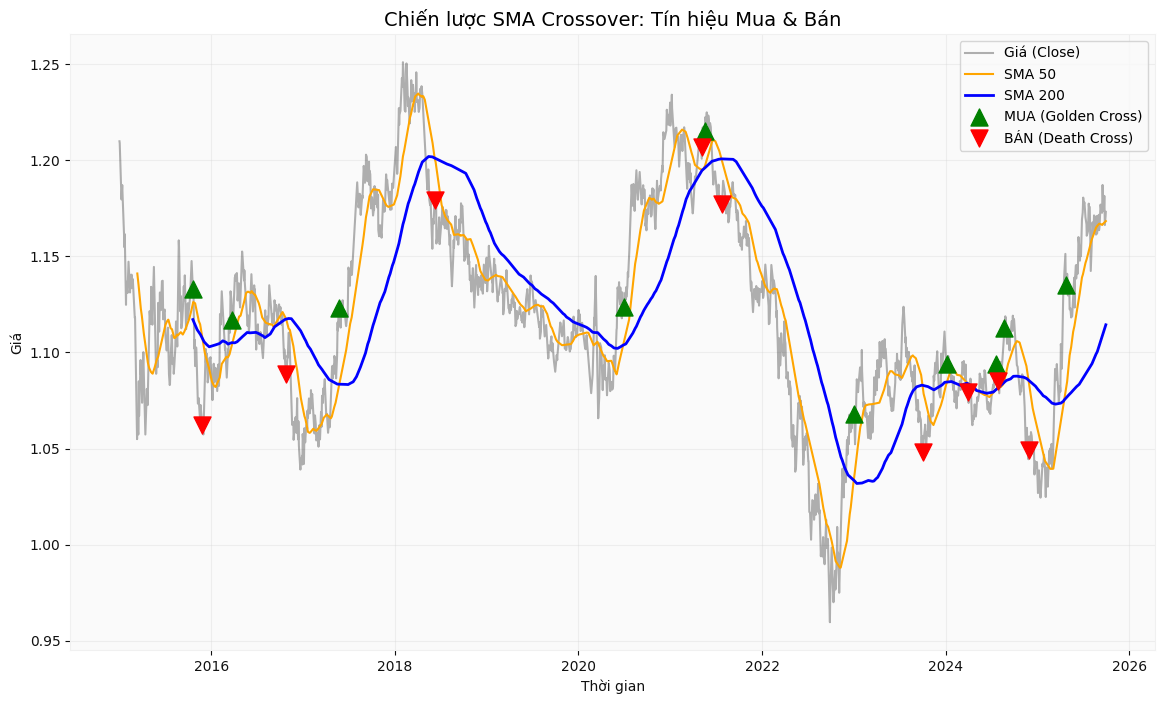

In [265]:
# --- PLOT SIGNAL TRADING ---

results = strategy_sma_crossover(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results['Position_Change'] = results['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals = results[results['Position_Change'] == 1]
sell_signals = results[results['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results.index, results['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results.index, results['SMA_50'], label='SMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results.index, results['SMA_200'], label='SMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals.index, buy_signals['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals.index, sell_signals['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược SMA Crossover: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

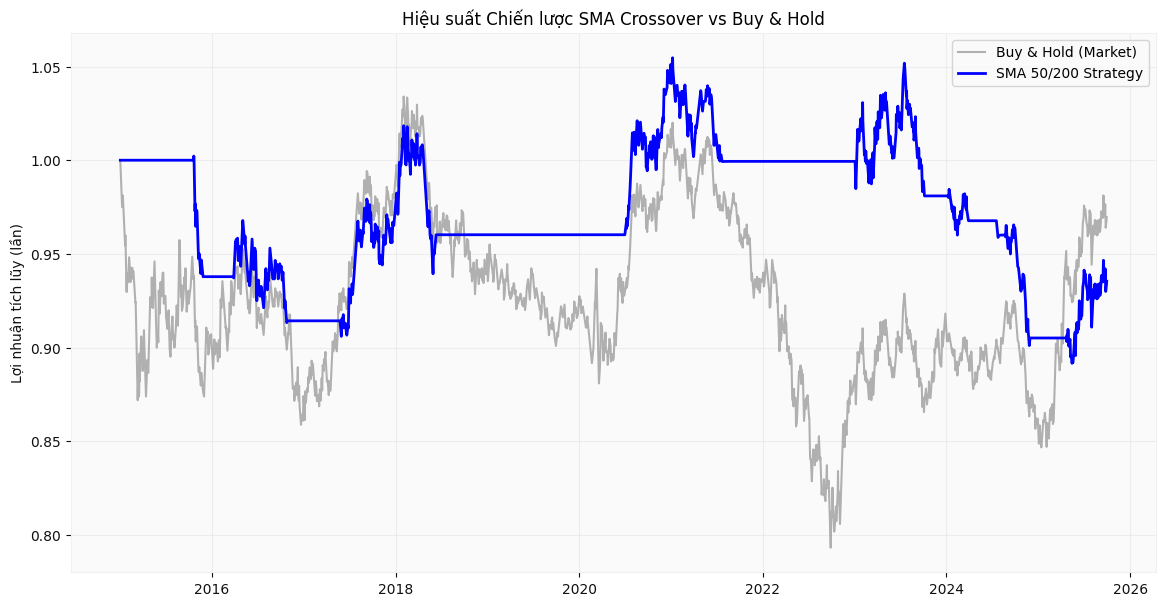

Lợi nhuận Buy & Hold: -3.03%
Lợi nhuận Chiến lược SMA: -6.46%


In [266]:
results = strategy_sma_crossover(df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='SMA 50/200 Strategy', color='blue', linewidth=2)

plt.title('Hiệu suất Chiến lược SMA Crossover vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược SMA: {total_ret_strategy:.2%}")

Tại sao Chiến lược chỉ sử dụng SMA không hiệu quả?
- Độ trễ (The Cost of Lag): Khi thị trường đảo chiều tăng mạnh, SMA phản ứng chậm. Bắt đầu mua khi giá đã tăng một đoạn khá xa, bỏ lỡ đoạn lợi nhuận từ đáy.
- Tín hiệu giả (Whipsaws in Sideways Markets): Khi thị trường đi ngang (không rõ xu hướng), giá cứ cắt lên rồi lại cắt xuống liên tục. Bị "mua đỉnh bán đáy" liên tiếp (mua xong giá giảm, bán xong giá tăng), khiến tài khoản bị bào mòn dần bởi các khoản lỗ nhỏ.

Cách khắc khục Lags:
- Chuyển sang EMA (Exponential Moving Average) là bước nâng cấp đầu tiên để khắc phục nhược điểm "trọng số bình đẳng" (equal weighting) của SMA.
- Lý thuyết: EMA gán trọng số lớn hơn cho dữ liệu giá gần nhất, giúp đường trung bình phản ứng nhanh hơn với sự thay đổi của thị trường và giảm bớt độ trễ (lag)
- Formula: $$EMA_{t} = \alpha \times P_{t} + (1 - \alpha) \times EMA_{t-1}$$ với $$\alpha = \frac{2}{N + 1}$$

## FIX LAGS
### EMA (Exponential Moving Average)

In [267]:
def strategy_ema(df):
    """
    Chiến lược: MUA khi EMA ngắn hạn cắt lên EMA dài hạn.
    BÁN (Giữ tiền) khi EMA ngắn hạn cắt xuống.
    """
    df_ema = df.copy()

    # --- Tính Chỉ báo EMA ---
    # Dùng ewm (Exponential Weighted Functions) để tính EMA
    # adjust=False giúp tính đệ quy: EMA_t = alpha * Price + (1-alpha) * EMA_t-1
    df_ema['EMA_50'] = df_ema['close'].ewm(span=50, adjust=False).mean()
    df_ema['EMA_200'] = df_ema['close'].ewm(span=200, adjust=False).mean()

    # --- Tạo Tín hiệu (Signal) ---
    df_ema['Signal'] = 0
    # Điều kiện MUA: EMA Ngắn > EMA Dài
    df_ema.loc[df_ema['EMA_50'] > df_ema['EMA_200'], 'Signal'] = 1

    # Xác định điểm Mua/Bán để vẽ lên biểu đồ (diff: 1=Mua, -1=Bán)
    df_ema['Order'] = df_ema['Signal'].diff()

    # --- Tính Lợi nhuận ---
    # Lợi nhuận thị trường (Buy & Hold)
    df_ema['Market_Return'] = df_ema['close'].pct_change()

    # Lợi nhuận Chiến lược (Dùng tín hiệu hôm qua để giao dịch hôm nay -> shift(1))
    df_ema['Strategy_Return'] = df_ema['Signal'].shift(1) * df_ema['Market_Return']

    # Tính giá trị tài sản tích lũy (Bắt đầu từ 1 đồng)
    df_ema['Cumulative_Market'] = (1 + df_ema['Market_Return'].fillna(0)).cumprod()
    df_ema['Cumulative_Strategy'] = (1 + df_ema['Strategy_Return'].fillna(0)).cumprod()

    return df_ema

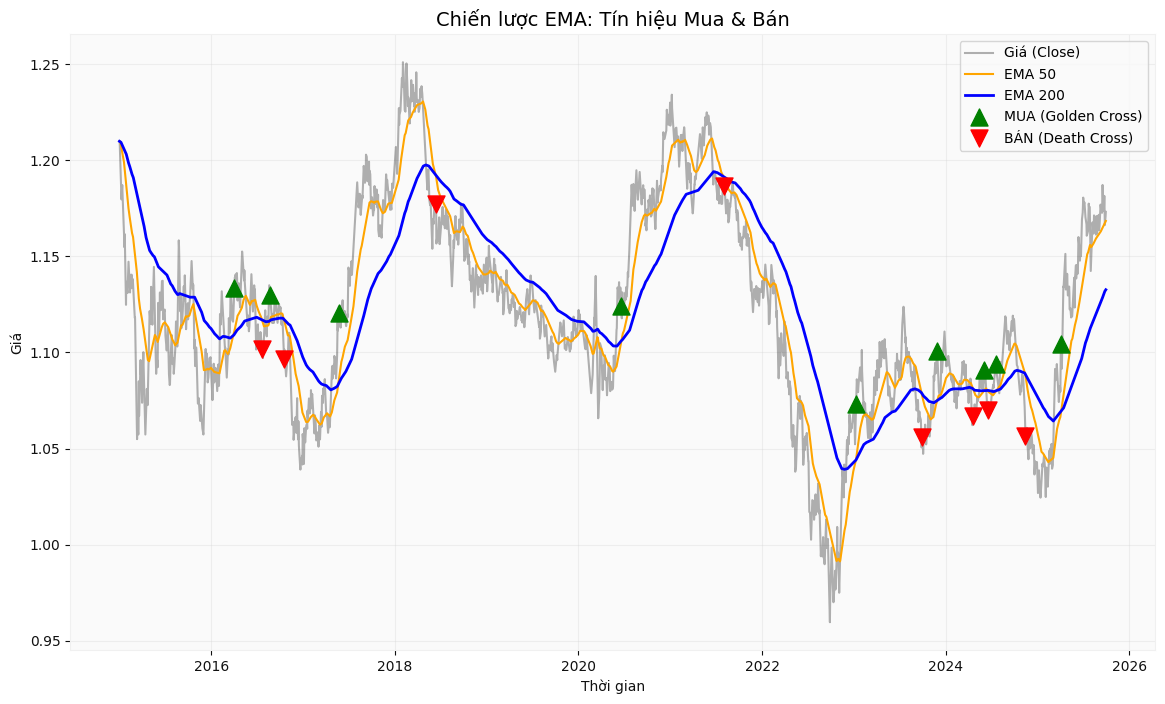

In [268]:
# --- PLOT SIGNAL TRADING ---

results2 = strategy_ema(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results2['Position_Change'] = results2['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals2 = results2[results2['Position_Change'] == 1]
sell_signals2 = results2[results2['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results2.index, results2['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results2.index, results2['EMA_50'], label='EMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results2.index, results2['EMA_200'], label='EMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals2.index, buy_signals2['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals2.index, sell_signals2['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược EMA: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

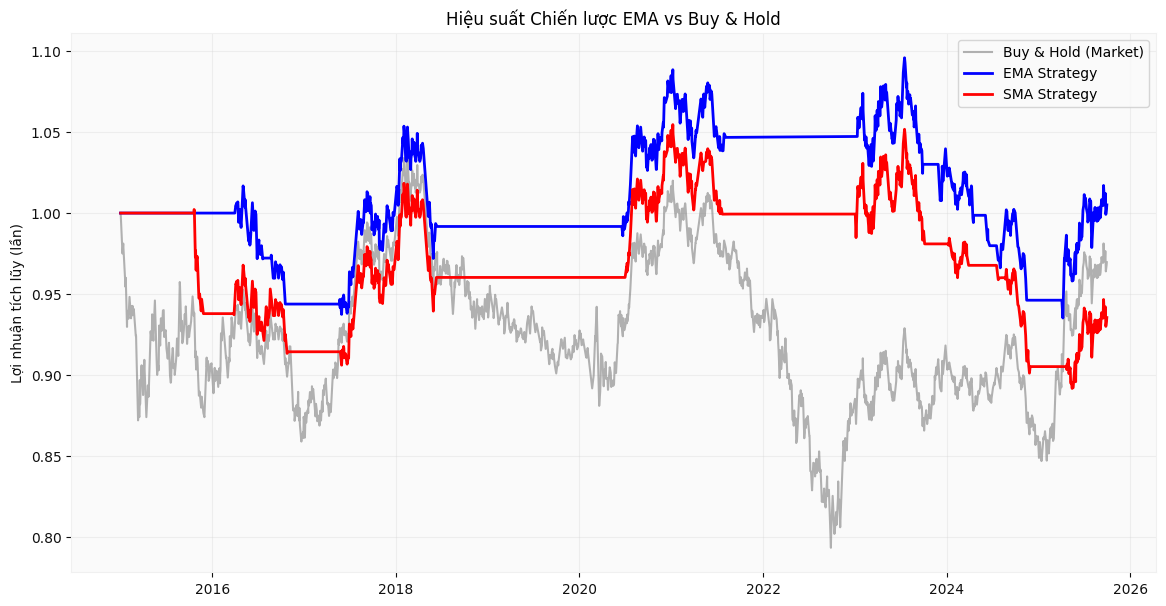

Lợi nhuận Buy & Hold: -3.03%
Lợi nhuận Chiến lược EMA: 0.51%
Lợi nhuận Chiến lược SMA: -6.46%


In [269]:
results = strategy_ema(df)
results2 = strategy_sma_crossover(df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='EMA Strategy', color='blue', linewidth=2)
plt.plot(results.index, results2['Cumulative_Strategy'], label='SMA Strategy', color='red', linewidth=2)

plt.title('Hiệu suất Chiến lược EMA vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
total_ret_strategy2 = results2['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược EMA: {total_ret_strategy:.2%}")
print(f"Lợi nhuận Chiến lược SMA: {total_ret_strategy2:.2%}")

Nếu xét về khả năng bảo vệ vốn khi thị trường sập (Bear Market) thì sao? Ta đi tính Max Drawdown để thấy rõ biểu hiện.

Max Drawdown (MDD) đo lường mức giảm phần trăm lớn nhất từ một đỉnh (Peak) xuống một đáy (Trough) xảy ra sau đó, trước khi một đỉnh mới được thiết lập.$$MDD = \min_{t \in (0, T)} \left( \frac{V_t - P_t}{P_t} \right)$$
Trong đó:
- $V_t$: Giá trị tài sản (Portfolio Value) tại thời điểm $t$.
- $P_t$: Giá trị đỉnh cao nhất đạt được trước thời điểm $t$ (Running Maximum).
$$P_t = \max_{\tau \in (0, t)} V_\tau$$

Chiến lược      | Max Drawdown (Rủi ro) | Lợi nhuận      
-------------------------------------------------------
Buy & Hold      | -23.29%                | -3.03%
SMA Strategy    | -15.46%                | -6.46%
EMA Strategy    | -14.67%                | 0.51%


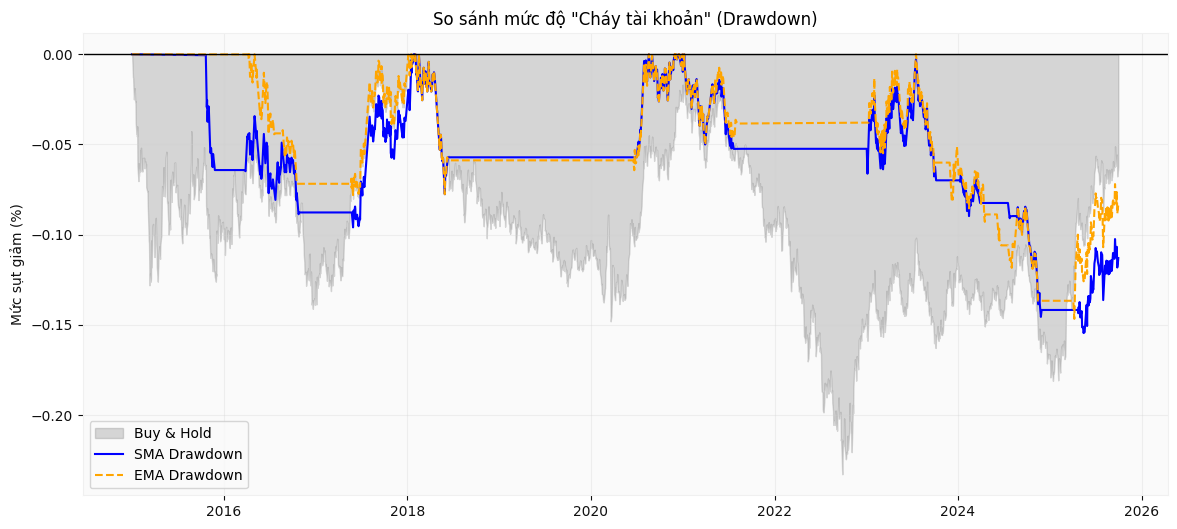

In [270]:

SHORT = 50
LONG = 200

# 1. Tính toán Chiến lược (SMA & EMA)
data = df.copy()
data['Ret'] = data['close'].pct_change() # Lợi nhuận hàng ngày của thị trường

# --- Chiến lược SMA ---
data['SMA_S'] = data['close'].rolling(window=SHORT).mean()
data['SMA_L'] = data['close'].rolling(window=LONG).mean()
data['Sig_SMA'] = np.where(data['SMA_S'] > data['SMA_L'], 1, 0)
data['Ret_SMA'] = data['Sig_SMA'].shift(1) * data['Ret'] # Lợi nhuận SMA

# --- Chiến lược EMA ---
data['EMA_S'] = data['close'].ewm(span=SHORT, adjust=False).mean()
data['EMA_L'] = data['close'].ewm(span=LONG, adjust=False).mean()
data['Sig_EMA'] = np.where(data['EMA_S'] > data['EMA_L'], 1, 0)
data['Ret_EMA'] = data['Sig_EMA'].shift(1) * data['Ret'] # Lợi nhuận EMA

# 2. Tính Tích lũy (Cumulative Return)
# Buy & Hold (Market)
data['Cum_Mkt'] = (1 + data['Ret'].fillna(0)).cumprod()
data['Cum_SMA'] = (1 + data['Ret_SMA'].fillna(0)).cumprod()
data['Cum_EMA'] = (1 + data['Ret_EMA'].fillna(0)).cumprod()

# 3. Tính Drawdown (Vùng sụt giảm)
def calc_dd(series):
    peak = series.cummax()
    return (series - peak) / peak

data['DD_Mkt'] = calc_dd(data['Cum_Mkt'])
data['DD_SMA'] = calc_dd(data['Cum_SMA'])
data['DD_EMA'] = calc_dd(data['Cum_EMA'])

# 4. In Kết quả So sánh
mdd_mkt = data['DD_Mkt'].min()
mdd_sma = data['DD_SMA'].min()
mdd_ema = data['DD_EMA'].min()

print(f"{'Chiến lược':<15} | {'Max Drawdown (Rủi ro)':<20} | {'Lợi nhuận':<15}")
print("-" * 55)
print(f"{'Buy & Hold':<15} | {mdd_mkt:.2%}                | {data['Cum_Mkt'].iloc[-1]-1:.2%}")
print(f"{'SMA Strategy':<15} | {mdd_sma:.2%}                | {data['Cum_SMA'].iloc[-1]-1:.2%}")
print(f"{'EMA Strategy':<15} | {mdd_ema:.2%}                | {data['Cum_EMA'].iloc[-1]-1:.2%}")

# 5. Vẽ Biểu đồ "Underwater" (So sánh độ sâu khi sập)
plt.figure(figsize=(14, 6))
plt.fill_between(data.index, data['DD_Mkt'], 0, color='gray', alpha=0.3, label='Buy & Hold')
plt.plot(data.index, data['DD_SMA'], color='blue', linewidth=1.5, label='SMA Drawdown')
plt.plot(data.index, data['DD_EMA'], color='orange', linewidth=1.5, linestyle='--', label='EMA Drawdown')

plt.title('So sánh mức độ "Cháy tài khoản" (Drawdown)')
plt.ylabel('Mức sụt giảm (%)')
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### DEMA (Double exponential moving average)
DEMA là một công thức toán học thông minh để cộng thêm vận tốc vào đường trung bình, giúp nó bắt kịp giá hiện tại (zero lag).
Formula:$$DEMA = 2 \times EMA_N - EMA(EMA_N)$$
Trong đó:
- $EMA_N$: Là đường EMA cấp 1 của giá (EMA thông thường).
- $EMA(EMA_N)$: Là đường EMA cấp 2 (Lấy đường EMA cấp 1 làm đầu vào để tính EMA tiếp lần nữa).
- $2 \times EMA_1 - EMA_2$: $EMA_2$ trễ hơn $EMA_1$.
- Hiệu số $(EMA_1 - EMA_2)$ đại diện cho "lỗi do độ trễ" (Lag error).
- Ta lấy $EMA_1$ cộng thêm phần lỗi này vào chính nó để "đẩy" đường chỉ báo về phía trước: $EMA_1 + (EMA_1 - EMA_2) = 2EMA_1 - EMA_2$.

In [271]:

def calculate_dema(series, span):

    # Tính EMA cấp 1
    ema1 = series.ewm(span=span, adjust=False).mean()
    # Tính EMA cấp 2 (EMA của EMA1)
    ema2 = ema1.ewm(span=span, adjust=False).mean()

    # Công thức khử trễ
    dema = 2 * ema1 - ema2
    return dema


def strategy_dema(df):
    data = df.copy()

    # --- A. TÍNH CHỈ BÁO ---
    # 1. Tính DEMA (Chiến lược chính)
    data['DEMA_50'] = calculate_dema(data['close'], span=50)
    data['DEMA_200'] = calculate_dema(data['close'], span=200)

    # --- B. TẠO TÍN HIỆU  ---
    data['Signal'] = 0
    # Mua khi DEMA Ngắn cắt lên DEMA Dài
    data.loc[data['DEMA_50'] > data['DEMA_200'], 'Signal'] = 1

    # --- C. TÍNH HIỆU SUẤT ---
    data['Market_Ret'] = data['close'].pct_change()
    data['Strategy_Ret'] = data['Signal'].shift(1) * data['Market_Ret']

    data['Cumulative_Market'] = (1 + data['Market_Ret'].fillna(0)).cumprod()
    data['Cumulative_Strategy'] = (1 + data['Strategy_Ret'].fillna(0)).cumprod()

    # Tính Drawdown
    peak = data['Cumulative_Strategy'].cummax()
    data['Drawdown'] = (data['Cumulative_Strategy'] - peak) / peak

    return data

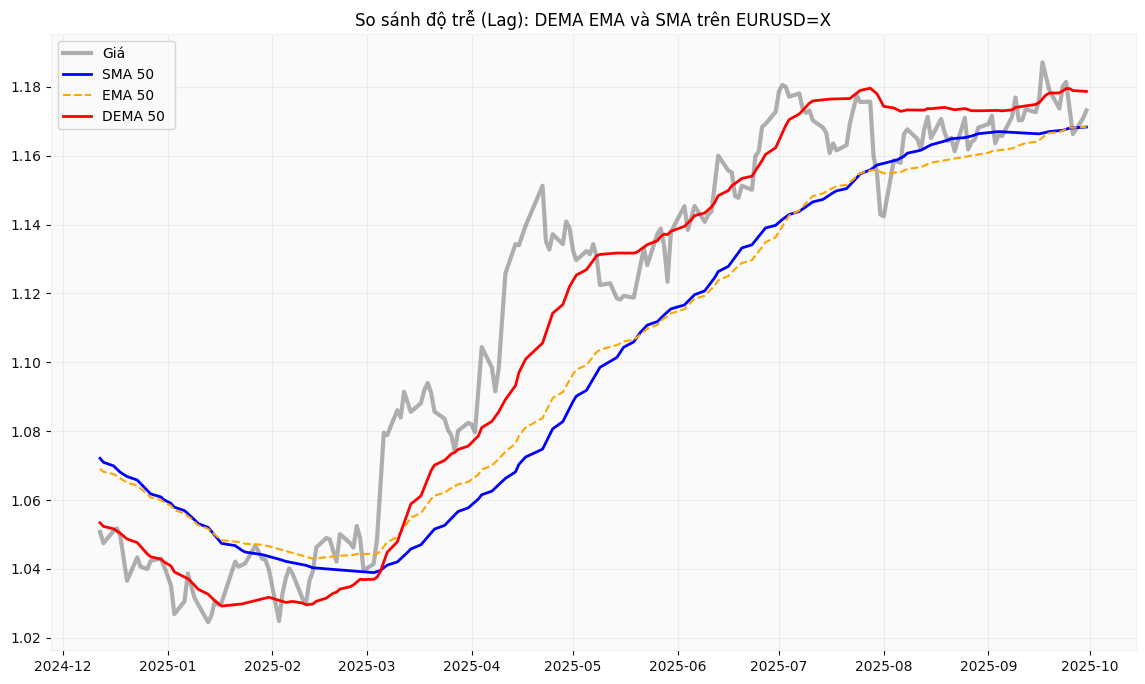

In [272]:
# --- VẼ BIỂU ĐỒ SO SÁNH ĐỘ TRỄ ---

results3 = strategy_sma_crossover(df)
results2 = strategy_ema(df)
results = strategy_dema(df)

subset = results.tail(200)
subset2 = results2.tail(200)
subset3 = results3.tail(200)
plt.figure(figsize=(14, 8))

# 1. Giá
plt.plot(subset.index, subset['close'], color='black', alpha=0.3, label='Giá', linewidth=3)

# 2. So sánh Short MA (50 ngày)
plt.plot(subset3.index, subset3['SMA_50'], color='blue', linewidth=2, label='SMA 50 ')
plt.plot(subset2.index, subset2['EMA_50'], color='orange', linestyle='--', label='EMA 50 ')
plt.plot(subset.index, subset['DEMA_50'], color='red', linewidth=2, label='DEMA 50 ')

plt.title(f'So sánh độ trễ (Lag): DEMA EMA và SMA trên {ticker}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


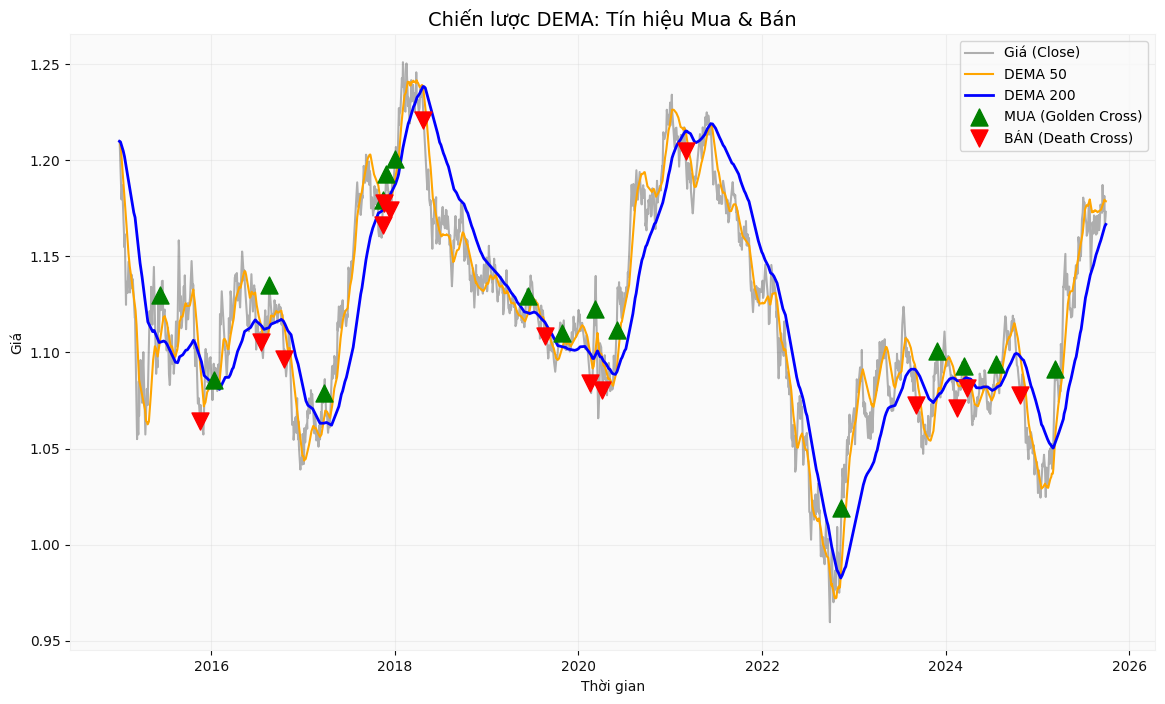

In [273]:
# --- PLOT SIGNAL TRADING ---

results = strategy_dema(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results['Position_Change'] = results['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals = results[results['Position_Change'] == 1]
sell_signals = results[results['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results.index, results['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results.index, results['DEMA_50'], label='DEMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results.index, results['DEMA_200'], label='DEMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals.index, buy_signals['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals.index, sell_signals['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược DEMA: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

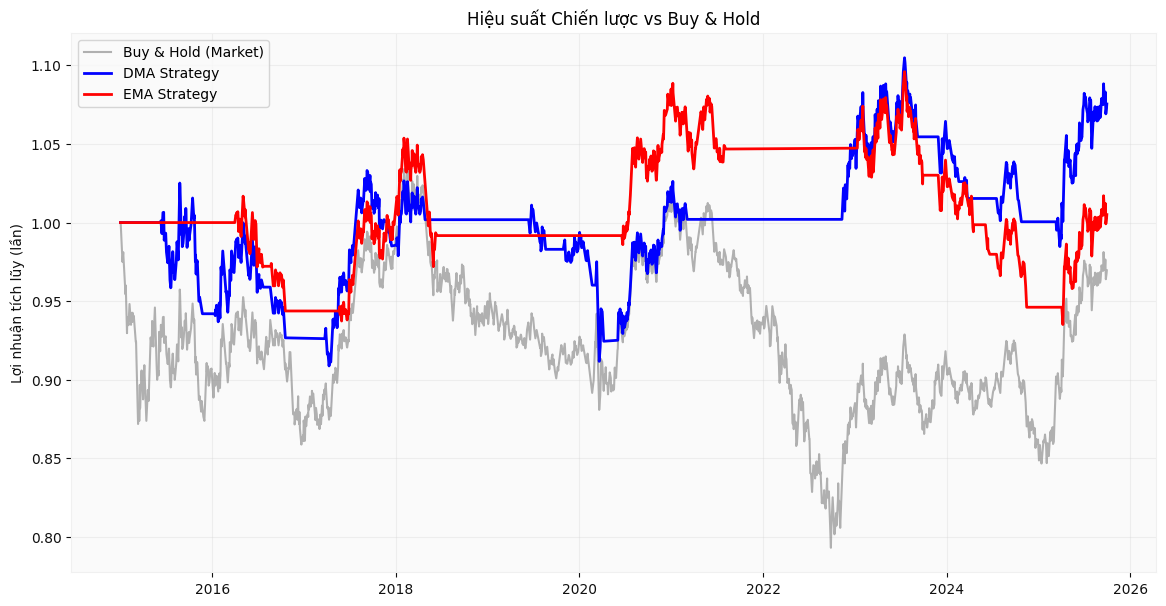

Lợi nhuận Buy & Hold: -3.03%
Lợi nhuận Chiến lược DMA: 7.54%
Lợi nhuận Chiến lược EMA: 0.51%


In [274]:
results = strategy_dema(df)
results2 = strategy_ema(df)


# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results2['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='DMA Strategy', color='blue', linewidth=2)
plt.plot(results.index, results2['Cumulative_Strategy'], label='EMA Strategy', color='red', linewidth=2)

plt.title('Hiệu suất Chiến lược vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
total_ret_strategy2 = results2['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược DMA: {total_ret_strategy:.2%}")
print(f"Lợi nhuận Chiến lược EMA: {total_ret_strategy2:.2%}")

Vì bám quá sát, DEMA cực kỳ nhạy cảm với mọi rung lắc nhỏ của thị trường.
Hậu quả: Khi thị trường Đi ngang (Sideways) hoặc không rõ xu hướng, giá cứ lên xuống nhẹ là DEMA đã cắt nhau loạn xạ.Do đó sẽ tạo ra nhiều tín hiệu giả (whipsaw): Mua xong giá giảm, Bán xong giá tăng. Tài khoản bị bào mòn bởi phí giao dịch và các khoản lỗ nhỏ liên tiếp. Thế nên cần biết thời điểm nào hợp lý để chiến lược được thực thi.

Chiến lược           | Max Drawdown (Rủi ro)     | Lợi nhuận cuối 
-----------------------------------------------------------------
Buy & Hold           | -23.29% (Thị trường)      | -3.03%
EMA Strategy         | -14.67% (Trễ hơn)         | 0.51%
DEMA Strategy        | -11.75% (Nhạy hơn)        | 7.54%


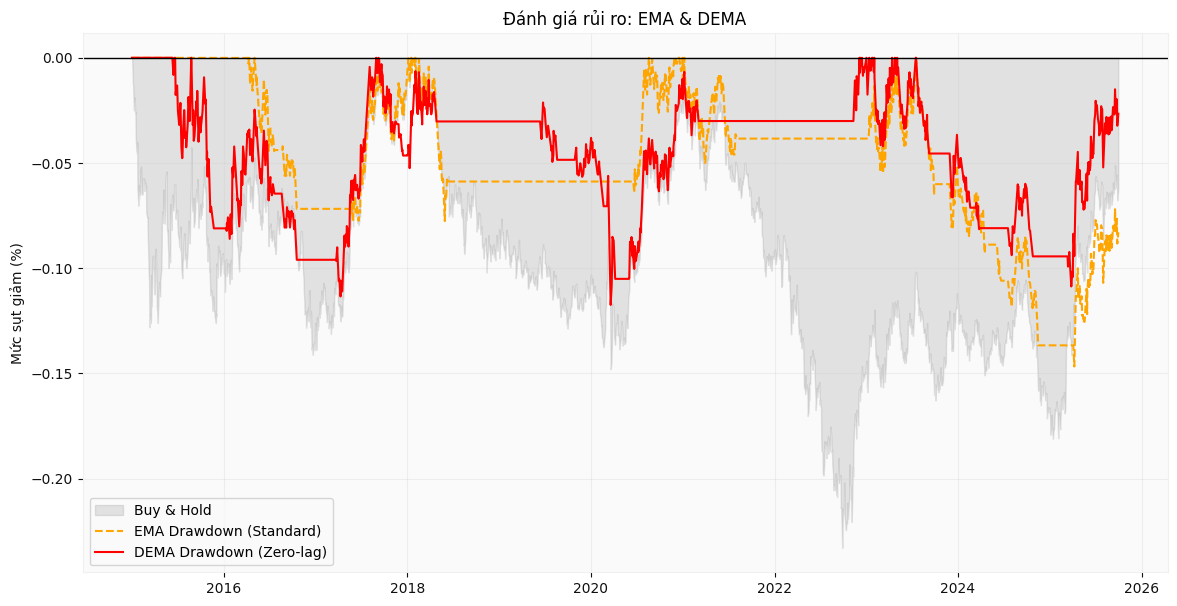

In [275]:

SHORT = 50
LONG = 200

# Hàm phụ trợ tính DEMA
def get_dema(series, span):
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    return 2 * ema1 - ema2

# 1. Tính toán Chiến lược
data = df.copy()
data['Ret'] = data['close'].pct_change() # Lợi nhuận thị trường

# --- Chiến lược EMA (Tiêu chuẩn) ---
data['EMA_S'] = data['close'].ewm(span=SHORT, adjust=False).mean()
data['EMA_L'] = data['close'].ewm(span=LONG, adjust=False).mean()
data['Sig_EMA'] = np.where(data['EMA_S'] > data['EMA_L'], 1, 0)
data['Ret_EMA'] = data['Sig_EMA'].shift(1) * data['Ret']

# --- Chiến lược DEMA (Zero-lag) ---
data['DEMA_S'] = get_dema(data['close'], span=SHORT)
data['DEMA_L'] = get_dema(data['close'], span=LONG)
data['Sig_DEMA'] = np.where(data['DEMA_S'] > data['DEMA_L'], 1, 0)
data['Ret_DEMA'] = data['Sig_DEMA'].shift(1) * data['Ret']

# 2. Tính Tích lũy & Drawdown
# Buy & Hold (để làm nền tham chiếu)
data['Cum_Mkt'] = (1 + data['Ret'].fillna(0)).cumprod()
data['Cum_EMA'] = (1 + data['Ret_EMA'].fillna(0)).cumprod()
data['Cum_DEMA'] = (1 + data['Ret_DEMA'].fillna(0)).cumprod()

def calc_dd(series):
    peak = series.cummax()
    return (series - peak) / peak

data['DD_Mkt'] = calc_dd(data['Cum_Mkt'])
data['DD_EMA'] = calc_dd(data['Cum_EMA'])
data['DD_DEMA'] = calc_dd(data['Cum_DEMA'])

# 3. In Kết quả So sánh
mdd_mkt = data['DD_Mkt'].min()
mdd_ema = data['DD_EMA'].min()
mdd_dema = data['DD_DEMA'].min()

print(f"{'Chiến lược':<20} | {'Max Drawdown (Rủi ro)':<25} | {'Lợi nhuận cuối':<15}")
print("-" * 65)
print(f"{'Buy & Hold':<20} | {mdd_mkt:.2%} (Thị trường)      | {data['Cum_Mkt'].iloc[-1]-1:.2%}")
print(f"{'EMA Strategy':<20} | {mdd_ema:.2%} (Trễ hơn)         | {data['Cum_EMA'].iloc[-1]-1:.2%}")
print(f"{'DEMA Strategy':<20} | {mdd_dema:.2%} (Nhạy hơn)        | {data['Cum_DEMA'].iloc[-1]-1:.2%}")

# 4. Vẽ Biểu đồ "Underwater" (So sánh độ sâu khi sập)
plt.figure(figsize=(14, 7))

# Vẽ nền Buy & Hold mờ để tham chiếu
plt.fill_between(data.index, data['DD_Mkt'], 0, color='gray', alpha=0.2, label='Buy & Hold')

# So sánh EMA và DEMA
plt.plot(data.index, data['DD_EMA'], color='orange', linewidth=1.5, linestyle='--', label='EMA Drawdown (Standard)')
plt.plot(data.index, data['DD_DEMA'], color='red', linewidth=1.5, label='DEMA Drawdown (Zero-lag)')

plt.title('Đánh giá rủi ro: EMA & DEMA')
plt.ylabel('Mức sụt giảm (%)')
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## WHIPSAWS
- Giảm độ trễ (Lag) $\rightarrow$ Tăng độ nhiễu (Noise/Whipsaw)
- DEMA được tạo ra để triệt tiêu độ trễ $\rightarrow$ Hệ quả tất yếu là nó cực kỳ ồn (Noisy)
- Hiện tượng DEMA cắt lên cắt xuống liên tục là "Chatter" (Sự rung lắc của tín hiệu).

### ADX

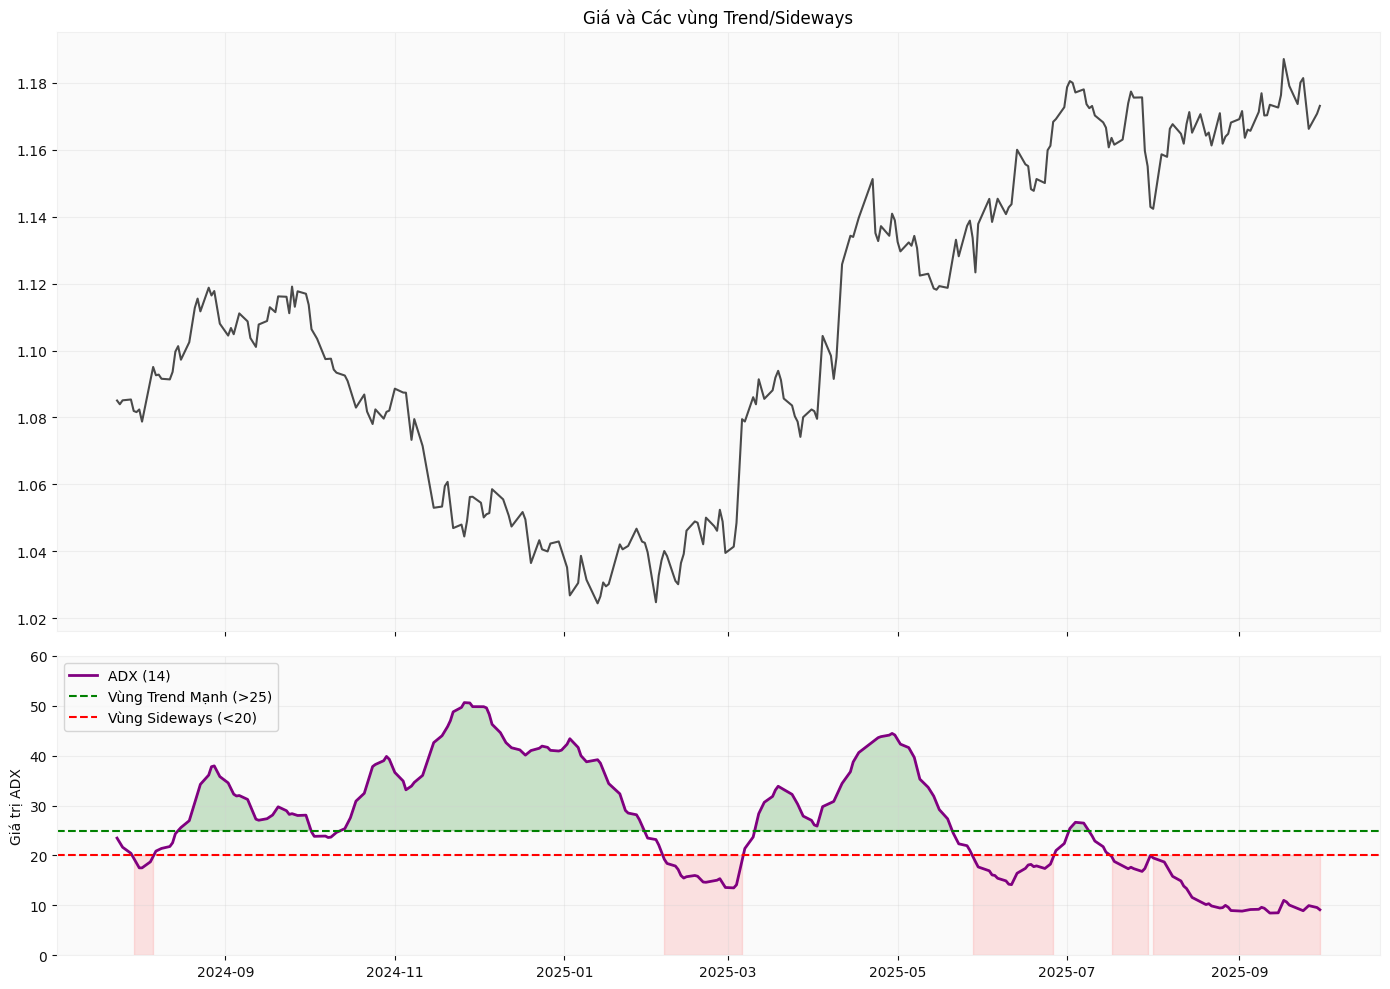

In [276]:
def calculate_adx_wilder(df, window=14):
    """
    Tính ADX theo công thức chuẩn của J. Welles Wilder.
    """
    data = df.copy()

    # 1. Tính True Range (TR) và Directional Movement (DM)
    data['H-L'] = data['high'] - data['low']
    data['H-PC'] = abs(data['high'] - data['close'].shift(1))
    data['L-PC'] = abs(data['low'] - data['close'].shift(1))

    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    data['UpMove'] = data['high'] - data['high'].shift(1)
    data['DownMove'] = data['low'].shift(1) - data['low']

    data['+DM'] = np.where((data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), data['UpMove'], 0)
    data['-DM'] = np.where((data['DownMove'] > data['UpMove']) & (data['DownMove'] > 0), data['DownMove'], 0)

    # 2. Hàm làm mượt Wilder (Wilder's Smoothing)
    # Công thức: Smooth_t = (Smooth_t-1 * (n-1) + Value_t) / n
    # Tương đương với ewm(alpha=1/n)
    alpha = 1 / window

    data['TR_Smooth'] = data['TR'].ewm(alpha=alpha, adjust=False).mean()
    data['+DM_Smooth'] = data['+DM'].ewm(alpha=alpha, adjust=False).mean()
    data['-DM_Smooth'] = data['-DM'].ewm(alpha=alpha, adjust=False).mean()

    # 3. Tính DI (+DI và -DI)
    data['+DI'] = 100 * (data['+DM_Smooth'] / data['TR_Smooth'])
    data['-DI'] = 100 * (data['-DM_Smooth'] / data['TR_Smooth'])

    # 4. Tính DX và ADX
    data['DX'] = 100 * abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])
    data['ADX'] = data['DX'].ewm(alpha=alpha, adjust=False).mean()

    return data

# --- VẼ BIỂU ĐỒ MINH HỌA ---
try:
    # Tính ADX
    df_adx = calculate_adx_wilder(df)

    # Lấy 300 ngày gần nhất để xem cho rõ
    subset = df_adx.tail(300)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Biểu đồ Giá
    ax1.plot(subset.index, subset['close'], color='black', alpha=0.7, label='Giá')
    ax1.set_title('Giá và Các vùng Trend/Sideways')
    ax1.grid(True, alpha=0.3)

    # Biểu đồ ADX
    ax2.plot(subset.index, subset['ADX'], color='purple', linewidth=2, label='ADX (14)')

    # Vẽ ngưỡng 20 và 25
    ax2.axhline(25, color='green', linestyle='--', label='Vùng Trend Mạnh (>25)')
    ax2.axhline(20, color='red', linestyle='--', label='Vùng Sideways (<20)')

    # Tô màu nền để phân biệt chế độ
    # Màu Xanh: Trend Mode (Dùng DEMA)
    ax2.fill_between(subset.index, 25, subset['ADX'], where=(subset['ADX'] >= 25), color='green', alpha=0.2)
    # Màu Đỏ: Sideways Mode (Dùng Mean Reversion hoặc Nghỉ)
    ax2.fill_between(subset.index, 0, 20, where=(subset['ADX'] <= 20), color='red', alpha=0.1)

    ax2.set_ylabel('Giá trị ADX')
    ax2.set_ylim(0, 60)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Lỗi:", e)

- ADX < 20: Nhiễu nhiều hơn Tín hiệu. $\rightarrow$ Tắt DEMA. Chuyển sang chiến lược Mean Reversion (đánh trong biên độ, mua thấp bán cao).
- ADX > 25: Tín hiệu rõ ràng. $\rightarrow$ Bật DEMA. Tắt các chỉ báo dao động (Oscillators) vì lúc này chúng sẽ báo quá mua/quá bán sai liên tục.

# MEAN REVERSION SIGNAL


--- BẢNG XẾP HẠNG HIỆU QUẢ ---
Chỉ số               | DEMA Gốc        | Regime Switching
------------------------------------------------------------
Lợi nhuận (Total)    | 2.50%  | 8.56% (Thắng)
Max Drawdown         | -19.54% | -12.09% (An toàn)
Sharpe Ratio         | 0.07            | 0.17 << QUAN TRỌNG
------------------------------------------------------------
=> KẾT LUẬN: Regime Switching TỐT HƠN vì nó tạo ra lợi nhuận ổn định hơn trên mỗi đơn vị rủi ro.


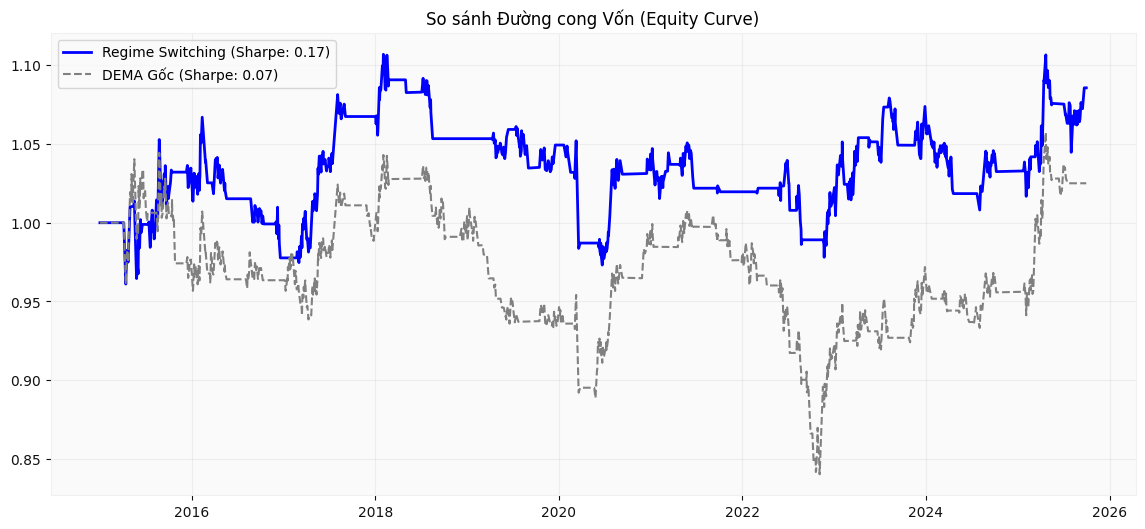

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CÁC HÀM TÍNH TOÁN (Giữ nguyên) ---
def calculate_dema(series, span):
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    return 2 * ema1 - ema2

def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_adx(df, window=14):
    data = df.copy()
    if 'Close' in data.columns:
        data = data.rename(columns={'Close': 'close', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Open': 'open'})
    data['TR'] = np.maximum(data['high'] - data['low'],
                            np.maximum(abs(data['high'] - data['close'].shift(1)),
                                       abs(data['low'] - data['close'].shift(1))))
    data['+DM'] = np.where((data['high'] - data['high'].shift(1)) > (data['low'].shift(1) - data['low']),
                           np.maximum(data['high'] - data['high'].shift(1), 0), 0)
    data['-DM'] = np.where((data['low'].shift(1) - data['low']) > (data['high'] - data['high'].shift(1)),
                           np.maximum(data['low'].shift(1) - data['low'], 0), 0)
    alpha = 1/window
    data['ATR'] = data['TR'].ewm(alpha=alpha, adjust=False).mean()
    data['+DI'] = 100 * (data['+DM'].ewm(alpha=alpha, adjust=False).mean() / data['ATR'])
    data['-DI'] = 100 * (data['-DM'].ewm(alpha=alpha, adjust=False).mean() / data['ATR'])
    data['DX'] = 100 * abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])
    return data['DX'].ewm(alpha=alpha, adjust=False).mean()

# --- 2. HÀM TÍNH SHARPE RATIO (MỚI THÊM) ---
def get_metrics(strategy_ret_series):
    """
    Trả về: Total Return, Max Drawdown, Sharpe Ratio
    """
    # 1. Total Return
    cum_ret = (1 + strategy_ret_series.fillna(0)).cumprod()
    total_ret = cum_ret.iloc[-1] - 1

    # 2. Max Drawdown
    peak = cum_ret.cummax()
    dd = (cum_ret - peak) / peak
    mdd = dd.min()

    # 3. Sharpe Ratio (Annualized)
    # Giả sử Risk-free rate = 0
    # Công thức: (Mean Daily Ret / Std Daily Ret) * sqrt(252)
    mean_ret = strategy_ret_series.mean()
    std_ret = strategy_ret_series.std()

    if std_ret == 0:
        sharpe = 0
    else:
        sharpe = (mean_ret / std_ret) * np.sqrt(252)

    return total_ret, mdd, sharpe

# --- 3. CHIẾN LƯỢC REGIME SWITCHING ---
def run_strategy_final(df_input):
    data = df_input.copy()
    if 'Close' in data.columns:
        data = data.rename(columns={'Close': 'close', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Adj Close': 'close'})

    # Chỉ báo
    data['DEMA_S'] = calculate_dema(data['close'], 20)
    data['DEMA_L'] = calculate_dema(data['close'], 50)
    data['RSI'] = calculate_rsi(data['close'], 14)
    data['ADX'] = calculate_adx(data, 14)

    signals = np.zeros(len(data))
    position = 0

    dema_s = data['DEMA_S'].values
    dema_l = data['DEMA_L'].values
    rsi = data['RSI'].values
    adx = data['ADX'].values

    for i in range(1, len(data)):
        if np.isnan(adx[i]): continue

        # --- Logic Regime ---
        if adx[i] > 25: # Trend Mode
            if position == 0 and dema_s[i] > dema_l[i]: position = 1
            elif position == 1 and dema_s[i] < dema_l[i]: position = 0
        elif adx[i] < 20: # Sideways Mode
            if position == 0 and rsi[i] < 30: position = 1
            elif position == 1 and rsi[i] > 70: position = 0
        else: # Grey Zone
            if position == 1 and dema_s[i] < dema_l[i]: position = 0

        signals[i] = position

    data['Signal'] = signals
    data['Ret'] = data['Signal'].shift(1) * data['close'].pct_change()
    data['Cum'] = (1 + data['Ret'].fillna(0)).cumprod()

    return data

# --- 4. CHẠY VÀ SO SÁNH ---
try:
    # 1. Chạy ADX Switching
    res_switch = run_strategy_final(df)

    # 2. Chạy DEMA Gốc (20/50)
    df_base = df.copy()
    if 'Close' in df_base.columns:
         df_base = df_base.rename(columns={'Close': 'close', 'Adj Close': 'close'})

    df_base['DEMA_S'] = calculate_dema(df_base['close'], 20)
    df_base['DEMA_L'] = calculate_dema(df_base['close'], 50)
    df_base['Signal'] = np.where(df_base['DEMA_S'] > df_base['DEMA_L'], 1, 0)
    df_base['Ret'] = df_base['Signal'].shift(1) * df_base['close'].pct_change()
    df_base['Cum'] = (1 + df_base['Ret'].fillna(0)).cumprod()

    # 3. Tính Chỉ số (Bao gồm Sharpe)
    ret_sw, mdd_sw, sharpe_sw = get_metrics(res_switch['Ret'])
    ret_bs, mdd_bs, sharpe_bs = get_metrics(df_base['Ret'])

    print(f"\n--- BẢNG XẾP HẠNG HIỆU QUẢ ---")
    print(f"{'Chỉ số':<20} | {'DEMA Gốc':<15} | {'Regime Switching':<15}")
    print("-" * 60)
    print(f"{'Lợi nhuận (Total)':<20} | {ret_bs:.2%} {'(Thắng)' if ret_bs>ret_sw else ''} | {ret_sw:.2%} {'(Thắng)' if ret_sw>ret_bs else ''}")
    print(f"{'Max Drawdown':<20} | {mdd_bs:.2%} {'(Sập sâu)' if mdd_bs < -0.3 else ''}| {mdd_sw:.2%} {'(An toàn)' if mdd_sw > mdd_bs else ''}")
    print(f"{'Sharpe Ratio':<20} | {sharpe_bs:.2f}            | {sharpe_sw:.2f} {'<< QUAN TRỌNG'}")

    print("-" * 60)
    if sharpe_sw > sharpe_bs:
        print("=> KẾT LUẬN: Regime Switching TỐT HƠN vì nó tạo ra lợi nhuận ổn định hơn trên mỗi đơn vị rủi ro.")
    else:
        print("=> KẾT LUẬN: DEMA Gốc TỐT HƠN (Có thể do thị trường Uptrend quá mạnh, phạt việc ra vào lệnh nhiều).")

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 6))
    plt.plot(res_switch.index, res_switch['Cum'], label=f'Regime Switching (Sharpe: {sharpe_sw:.2f})', color='blue', linewidth=2)
    plt.plot(df_base.index, df_base['Cum'], label=f'DEMA Gốc (Sharpe: {sharpe_bs:.2f})', color='gray', linestyle='--')
    plt.title('So sánh Đường cong Vốn (Equity Curve)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print("Lỗi:", e)

Sharpe < 1.0: Tệ. Rủi ro quá cao so với lợi nhuận.

Sharpe 1.0 - 2.0: Tốt. Chiến lược chấp nhận được.

Sharpe > 2.0: Rất Tốt.

Sharpe > 3.0: Xuất sắc (Thường chỉ thấy ở các quỹ định lượng High Frequency hoặc trong Uptrend thần thánh).

In [278]:
! git add .
! git commit -m "Update MA"
! git push


[main 7da9445] Update MA
 1 file changed, 87 insertions(+), 88 deletions(-)


To https://github.com/tamnguyen-2905/CF_Tam22110193.git
   586f186..7da9445  main -> main
